In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Directory with all .npy embedding files
EMBEDDINGS_DIR = "embeddings"
print(os.getcwd())
# Inspect what you currently have
if os.path.exists(EMBEDDINGS_DIR):
    print("Available files in embeddings/:")
    for f in os.listdir(EMBEDDINGS_DIR):
        print("  ", f)
else:
    print("embeddings/ directory NOT FOUND")

# Fill these file names to match your actual ones
embedding_configs = [
    {
        "name": "protbert",
        "embedding_path": os.path.join(EMBEDDINGS_DIR, "protbert_train.npy"),
        "ids_path":       os.path.join(EMBEDDINGS_DIR, "protbert_train_ids.npy"),
    },
]

Using device: cuda
e:\cafa6-protein-function-analysis
Available files in embeddings/:
   protbert_test.npy
   protbert_test_ids.npy
   protbert_train.npy
   protbert_train_ids.npy
   test_esm2_embeddings.parquet
   train_esm2_embeddings.parquet


In [5]:
BASE_DIR = "cafa-6-protein-function-prediction"
TRAIN_DIR = f"{BASE_DIR}/Train"
TEST_DIR = f"{BASE_DIR}/Test"

In [6]:
terms_df = pd.read_csv(f"{TRAIN_DIR}/train_terms.tsv", sep="\t")
# Each protein can appear multiple times — group all terms into a list
terms_grouped = (
    terms_df.groupby("EntryID")["term"]
    .apply(list)
    .reset_index()
    .rename(columns={"EntryID": "protein_id"})
)
print(terms_grouped.head())

   protein_id          term
0  A0A023FBW4  [GO:0019958]
1  A0A023FBW7  [GO:0019957]
2  A0A023FDY8  [GO:0019957]
3  A0A023FF81  [GO:0019958]
4  A0A023FFB5  [GO:0019957]


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import joblib


###############################################
# LOAD TRAIN TERMS
###############################################

terms_df = pd.read_csv(f"{TRAIN_DIR}/train_terms.tsv", sep="\t")

terms_grouped = (
    terms_df.groupby("EntryID")["term"]
    .apply(list)
    .reset_index()
    .rename(columns={"EntryID": "protein_id"})
)



###############################################
# UNIFIED EMBEDDING LOADER (WITH CONFIG)
###############################################

def load_embeddings(cfg):
    emb_path = cfg["embedding_path"]
    ids_path = cfg["ids_path"]
    emb_name = cfg["name"]

    print(f"\n=== Loading embedding set: {emb_name} ===")
    print("Embedding file:", emb_path)
    print("ID file:", ids_path)

    # --------------------------
    # CASE A: Parquet embeddings
    # --------------------------
    if emb_path.endswith(".parquet"):
        emb_df = pd.read_parquet(emb_path)

        # Must contain protein_id column
        if "protein_id" not in emb_df.columns:
            raise ValueError("Parquet file must contain 'protein_id' column.")

        merged = emb_df.merge(terms_grouped, on="protein_id", how="inner")
        print("Merged shape:", merged.shape)

        X = merged.drop(columns=["protein_id", "term"]).astype(float).values
        Y_raw = merged["term"].values
        protein_ids = merged["protein_id"].values
        return protein_ids, X, Y_raw

    # --------------------------
    # CASE B: Numpy embeddings
    # --------------------------
    elif emb_path.endswith(".npy"):
        emb = np.load(emb_path)
        ids = np.load(ids_path, allow_pickle=True).astype(str)

        emb_df = pd.DataFrame(emb)
        emb_df["protein_id"] = ids

        merged = emb_df.merge(terms_grouped, on="protein_id", how="inner")
        print("Merged shape:", merged.shape)

        X = merged.drop(columns=["protein_id", "term"]).astype(float).values
        Y_raw = merged["term"].values
        protein_ids = merged["protein_id"].values
        return protein_ids, X, Y_raw

    else:
        raise ValueError(f"Unsupported file format: {emb_path}")

from sklearn.preprocessing import MultiLabelBinarizer
import joblib
from sklearn.model_selection import train_test_split
def prepare_dataset(cfg):
    protein_ids, X, Y_raw = load_embeddings(cfg)

    print("X shape:", X.shape)

    mlb = MultiLabelBinarizer(sparse_output=True)
    Y = mlb.fit_transform(Y_raw)

    # Save a unique mlb per embedding set
    joblib.dump(mlb, f"mlb_{cfg['name']}.pkl")

    print("Y shape:", Y.shape)

    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    print("Train:", X_train.shape, Y_train.shape)
    print("Val:  ", X_val.shape, Y_val.shape)

    return X_train, X_val, Y_train, Y_val, mlb


In [8]:
for cfg in embedding_configs:
    print("Processing:", cfg["name"])
    X_train, X_val, Y_train, Y_val, mlb = prepare_dataset(cfg)


Processing: protbert

=== Loading embedding set: protbert ===
Embedding file: embeddings\protbert_train.npy
ID file: embeddings\protbert_train_ids.npy
Merged shape: (82404, 1026)
X shape: (82404, 1024)
Y shape: (82404, 26125)
Train: (65923, 1024) (65923, 26125)
Val:   (16481, 1024) (16481, 26125)


In [9]:
import torch
import torch.nn as nn

class LogisticRegressionClassifier(nn.Module):
    """
    Multi-label logistic regression model:
    y = sigmoid(Wx + b)
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # logits → we apply sigmoid in the loss or evaluation
        return self.linear(x)
model = LogisticRegressionClassifier(
    input_dim=X_train.shape[1],
    output_dim=Y_train.shape[1]
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate_f1(model, loader, threshold=0.5):
    model.eval()
    preds_list = []
    labels_list = []

    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)

        preds = (probs > threshold).float().cpu().numpy()
        labels = yb.cpu().numpy()

        preds_list.append(preds)
        labels_list.append(labels)

    preds = np.vstack(preds_list)
    labels = np.vstack(labels_list)

    return f1_score(labels, preds, average="micro", zero_division=0)


In [12]:
lr_grid = [1e-2, 1e-3, 5e-4]
weight_decay_grid = [0.0, 1e-4, 1e-3]
batch_sizes = [256, 512]
epochs = 5
n_splits = 3
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def run_lr_cv(X, Y, lr_grid, weight_decay_grid, batch_sizes):
    results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X_tensor = torch.tensor(X).float()
    Y_tensor = torch.tensor(Y.toarray()).float()  # multilabel sparse → dense

    dataset = TensorDataset(X_tensor, Y_tensor)

    for lr in lr_grid:
        for wd in weight_decay_grid:
            for bs in batch_sizes:

                print(f"\n=== LR={lr}, WD={wd}, BS={bs} ===")

                fold_final_f1_scores = []     # F1 for each fold (final epoch)
                fold_train_losses_all = []     # training loss curves per fold
                fold_val_losses_all = []       # validation loss curves per fold
                fold_f1_curves_all = []        # validation F1 curves per fold  ← FIXED

                for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):

                    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=bs, shuffle=True)
                    val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=bs)

                    model = LogisticRegressionClassifier(X.shape[1], Y.shape[1]).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    criterion = nn.BCEWithLogitsLoss()

                    train_losses = []  # per-epoch
                    val_losses = []    # per-epoch
                    val_f1_scores = [] # per-epoch

                    for epoch in range(epochs):
                        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
                        val_loss = evaluate_loss(model, val_loader, criterion)
                        val_f1 = evaluate_f1(model, val_loader)

                        train_losses.append(train_loss)
                        val_losses.append(val_loss)
                        val_f1_scores.append(val_f1)

                        print(
                            f"Fold {fold+1}/{n_splits} Epoch {epoch+1}/{epochs} "
                            f"| Train {train_loss:.4f} | Val {val_loss:.4f} | F1 {val_f1:.4f}"
                        )

                    # Store per-fold curves
                    fold_train_losses_all.append(train_losses)
                    fold_val_losses_all.append(val_losses)
                    fold_f1_curves_all.append(val_f1_scores)

                    # Final epoch F1 for cross-fold comparison
                    fold_final_f1_scores.append(val_f1_scores[-1])

                # Average F1 across folds
                mean_f1 = np.mean(fold_final_f1_scores)

                results.append({
                    "lr": lr,
                    "weight_decay": wd,
                    "batch_size": bs,
                    "mean_f1": mean_f1,
                    "train_losses": fold_train_losses_all,
                    "val_losses": fold_val_losses_all,
                    "val_f1_curve": fold_f1_curves_all,  # fixed
                })

                print(f"-> Mean F1: {mean_f1:.4f}")

    return results
def plot_training_curves(result):
    train_losses = np.mean(result["train_losses"], axis=0)
    val_losses   = np.mean(result["val_losses"], axis=0)
    val_f1       = np.mean(result["val_f1_curve"], axis=0)

    plt.figure(figsize=(12,4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()

    # F1 curve
    plt.subplot(1, 2, 2)
    plt.plot(val_f1, label="Validation F1", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Epoch")
    plt.legend()

    plt.show()
def plot_f1_vs_hyperparams(results):
    labels = []
    scores = []

    for r in results:
        label = f"LR={r['lr']}, WD={r['weight_decay']}, BS={r['batch_size']}"
        labels.append(label)
        scores.append(r["mean_f1"])

    plt.figure(figsize=(12,6))
    plt.barh(labels, scores)
    plt.xlabel("Mean F1 Score")
    plt.title("Logistic Regression Hyperparameter Sweep")
    plt.tight_layout()
    plt.show()



=== LR=0.01, WD=0.0, BS=256 ===
Fold 1/3 Epoch 1/5 | Train 0.0332 | Val 0.0043 | F1 0.0824
Fold 1/3 Epoch 2/5 | Train 0.0033 | Val 0.0027 | F1 0.0680
Fold 1/3 Epoch 3/5 | Train 0.0024 | Val 0.0022 | F1 0.0656
Fold 1/3 Epoch 4/5 | Train 0.0021 | Val 0.0020 | F1 0.0760
Fold 1/3 Epoch 5/5 | Train 0.0019 | Val 0.0019 | F1 0.0940
Fold 2/3 Epoch 1/5 | Train 0.0332 | Val 0.0043 | F1 0.0639
Fold 2/3 Epoch 2/5 | Train 0.0033 | Val 0.0027 | F1 0.0824
Fold 2/3 Epoch 3/5 | Train 0.0024 | Val 0.0022 | F1 0.0749
Fold 2/3 Epoch 4/5 | Train 0.0021 | Val 0.0020 | F1 0.0931
Fold 2/3 Epoch 5/5 | Train 0.0019 | Val 0.0019 | F1 0.0904
Fold 3/3 Epoch 1/5 | Train 0.0331 | Val 0.0043 | F1 0.0659
Fold 3/3 Epoch 2/5 | Train 0.0033 | Val 0.0027 | F1 0.0746
Fold 3/3 Epoch 3/5 | Train 0.0024 | Val 0.0022 | F1 0.0893
Fold 3/3 Epoch 4/5 | Train 0.0021 | Val 0.0020 | F1 0.0963
Fold 3/3 Epoch 5/5 | Train 0.0019 | Val 0.0019 | F1 0.1004
-> Mean F1: 0.0949

=== LR=0.01, WD=0.0, BS=512 ===
Fold 1/3 Epoch 1/5 | Train 0.0

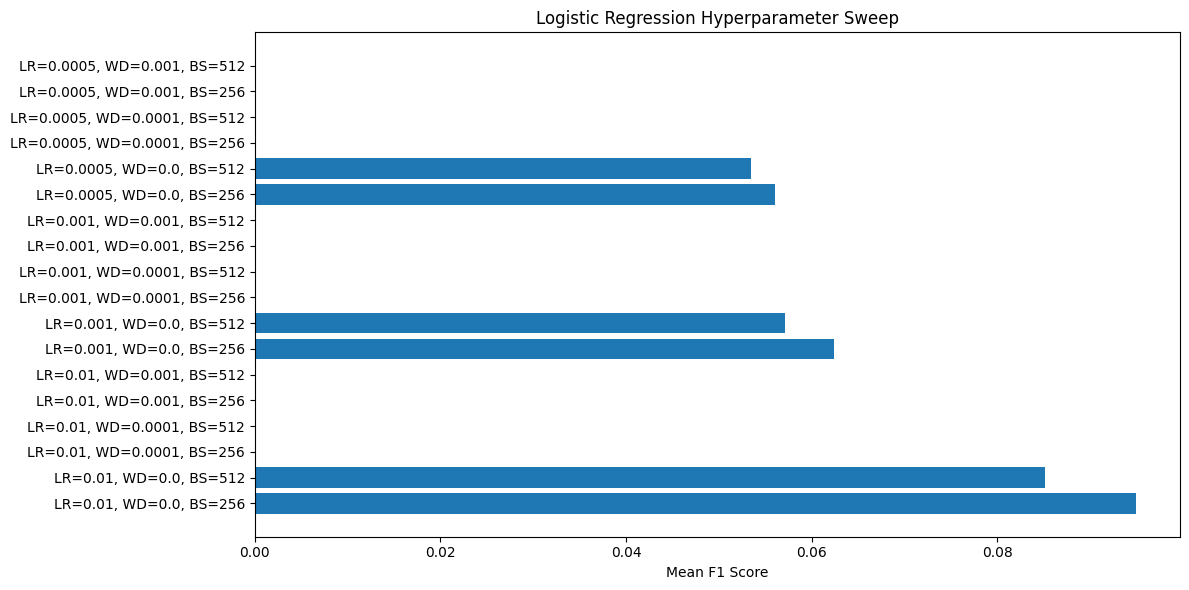

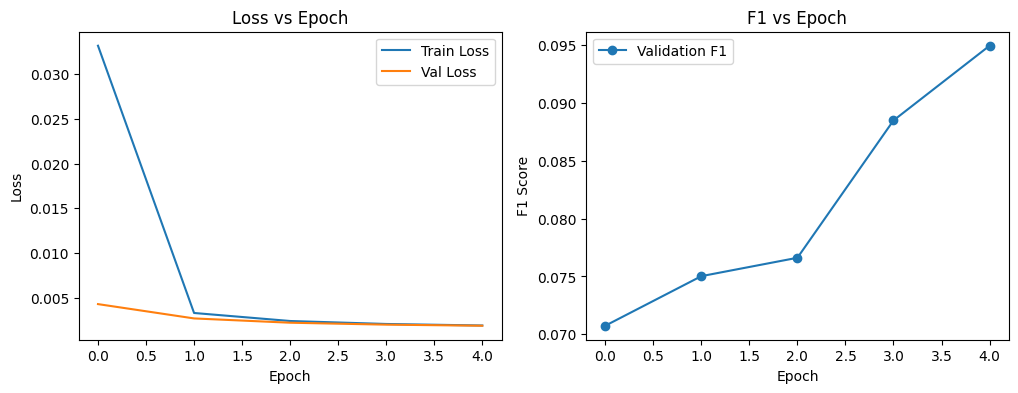

Best hyperparameters: {'lr': 0.01, 'weight_decay': 0.0, 'batch_size': 256, 'mean_f1': 0.09492046548397785, 'train_losses': [[0.033172501358287934, 0.003304050716360358, 0.0024103286015443675, 0.002078679875769328, 0.001908964274094357], [0.03322143527380374, 0.003312399894195201, 0.002412517641432455, 0.002079775229219278, 0.0019097675506985123], [0.03313259438027395, 0.0033022941175311943, 0.002407028075318542, 0.002075100691422248, 0.0019054202790693307]], 'val_losses': [[0.004304117458460341, 0.0027003601632707153, 0.0022198158913674477, 0.0020026230253808973, 0.001882155614129487], [0.00427169395068019, 0.002683487204266718, 0.002208392165594133, 0.0019944852980585616, 0.0018760072937035357], [0.00431931260094193, 0.0027090066862628685, 0.0022263522735427544, 0.0020094733894139337, 0.0018889393930476763]], 'val_f1_curve': [[0.08244698163071355, 0.06803361255434207, 0.06561735616292673, 0.07601056507334294, 0.09402450225746775], [0.06387981190722881, 0.08238634509317581, 0.074942870

In [13]:
results = run_lr_cv(
    X_train,
    Y_train,
    lr_grid=lr_grid,
    weight_decay_grid=weight_decay_grid,
    batch_sizes=batch_sizes
)

plot_f1_vs_hyperparams(results)

# Show the best config's training curves
best = max(results, key=lambda r: r["mean_f1"])
plot_training_curves(best)

print("Best hyperparameters:", best)


In [14]:
class MLPClassifier(nn.Module):
    """
    3-layer MLP for multilabel classification:
    input → h1 → h2 → h3 → output
    """
    def __init__(self, input_dim, output_dim, hidden_dims=[512, 256, 128], dropout=0.3):
        super().__init__()

        h1, h2, h3 = hidden_dims

        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(h3, output_dim),
        )

    def forward(self, x):
        return self.net(x)  # logits


In [15]:
def run_mlp_cv(X, Y, hidden_sizes_grid, dropout_grid, lr_grid, batch_sizes):

    results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    X_tensor = torch.tensor(X).float()
    Y_tensor = torch.tensor(Y.toarray()).float()

    dataset = TensorDataset(X_tensor, Y_tensor)

    global_best_f1 = -1
    global_best_model_state = None
    global_best_config = None

    for h1, h2, h3 in hidden_sizes_grid:
        for dropout in dropout_grid:
            for lr in lr_grid:
                for bs in batch_sizes:

                    print(f"\n=== H=({h1},{h2},{h3}), Dropout={dropout}, LR={lr}, BS={bs} ===")

                    fold_final_f1 = []
                    fold_train_losses = []
                    fold_val_losses = []
                    fold_f1_curves = []

                    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):

                        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=bs, shuffle=True)
                        val_loader   = DataLoader(Subset(dataset, val_idx),   batch_size=bs)

                        model = MLPClassifier(
                            input_dim=X.shape[1],
                            output_dim=Y.shape[1],
                            hidden_dims=[h1, h2, h3],
                            dropout=dropout
                        ).to(device)

                        criterion = nn.BCEWithLogitsLoss()
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                        train_losses = []
                        val_losses = []
                        val_f1_scores = []

                        for epoch in range(epochs):
                            train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
                            val_loss = evaluate_loss(model, val_loader, criterion)
                            val_f1 = evaluate_f1(model, val_loader)

                            train_losses.append(train_loss)
                            val_losses.append(val_loss)
                            val_f1_scores.append(val_f1)

                            print(
                                f"Fold {fold+1}/{n_splits} Epoch {epoch+1}/{epochs} "
                                f"| Train {train_loss:.4f} | Val {val_loss:.4f} | F1 {val_f1:.4f}"
                            )

                        fold_train_losses.append(train_losses)
                        fold_val_losses.append(val_losses)
                        fold_f1_curves.append(val_f1_scores)
                        fold_final_f1.append(val_f1_scores[-1])

                    mean_f1 = np.mean(fold_final_f1)

                    result = {
                        "hidden_dims": (h1, h2, h3),
                        "dropout": dropout,
                        "lr": lr,
                        "batch_size": bs,
                        "mean_f1": mean_f1,
                        "train_losses": fold_train_losses,
                        "val_losses": fold_val_losses,
                        "val_f1_curve": fold_f1_curves
                    }

                    results.append(result)
                    print(f"-> Mean F1: {mean_f1:.4f}")

                    # 🔥 SAVE GLOBAL BEST MODEL
                    if mean_f1 > global_best_f1:
                        global_best_f1 = mean_f1
                        global_best_config = result

                        print("🔥 New Best Model Found! Saving state dict...")
                        global_best_model_state = {
                            k: v.cpu() for k, v in model.state_dict().items()
                        }

                        torch.save(global_best_model_state, "best_mlp_model.pt")

    print("\n============================")
    print(" BEST MLP CONFIG FOUND ")
    print("============================")
    print(global_best_config)
    print("Saved to: best_mlp_model.pt")

    return results, global_best_config


In [16]:
hidden_sizes_grid = [
    (512, 256, 128),
    (1024, 512, 256),
]

dropout_grid = [0.1, 0.3, 0.5]
lr_grid = [1e-3, 5e-4]
batch_sizes = [128, 256]
epochs = 5
n_splits = 3


In [17]:
results_mlp, best_mlp_config = run_mlp_cv(
    X_train, 
    Y_train,
    hidden_sizes_grid=hidden_sizes_grid,
    dropout_grid=dropout_grid,
    lr_grid=lr_grid,
    batch_sizes=batch_sizes
)



=== H=(512,256,128), Dropout=0.1, LR=0.001, BS=128 ===
Fold 1/3 Epoch 1/5 | Train 0.0280 | Val 0.0018 | F1 0.0000
Fold 1/3 Epoch 2/5 | Train 0.0019 | Val 0.0018 | F1 0.0156
Fold 1/3 Epoch 3/5 | Train 0.0019 | Val 0.0018 | F1 0.0069
Fold 1/3 Epoch 4/5 | Train 0.0018 | Val 0.0018 | F1 0.0392
Fold 1/3 Epoch 5/5 | Train 0.0018 | Val 0.0018 | F1 0.0484
Fold 2/3 Epoch 1/5 | Train 0.0292 | Val 0.0018 | F1 0.0000
Fold 2/3 Epoch 2/5 | Train 0.0019 | Val 0.0018 | F1 0.0216
Fold 2/3 Epoch 3/5 | Train 0.0019 | Val 0.0018 | F1 0.0240
Fold 2/3 Epoch 4/5 | Train 0.0018 | Val 0.0018 | F1 0.0550
Fold 2/3 Epoch 5/5 | Train 0.0018 | Val 0.0017 | F1 0.0582
Fold 3/3 Epoch 1/5 | Train 0.0288 | Val 0.0018 | F1 0.0000
Fold 3/3 Epoch 2/5 | Train 0.0019 | Val 0.0018 | F1 0.0000
Fold 3/3 Epoch 3/5 | Train 0.0019 | Val 0.0018 | F1 0.0000
Fold 3/3 Epoch 4/5 | Train 0.0018 | Val 0.0018 | F1 0.0139
Fold 3/3 Epoch 5/5 | Train 0.0018 | Val 0.0018 | F1 0.0633
-> Mean F1: 0.0566
🔥 New Best Model Found! Saving state dic

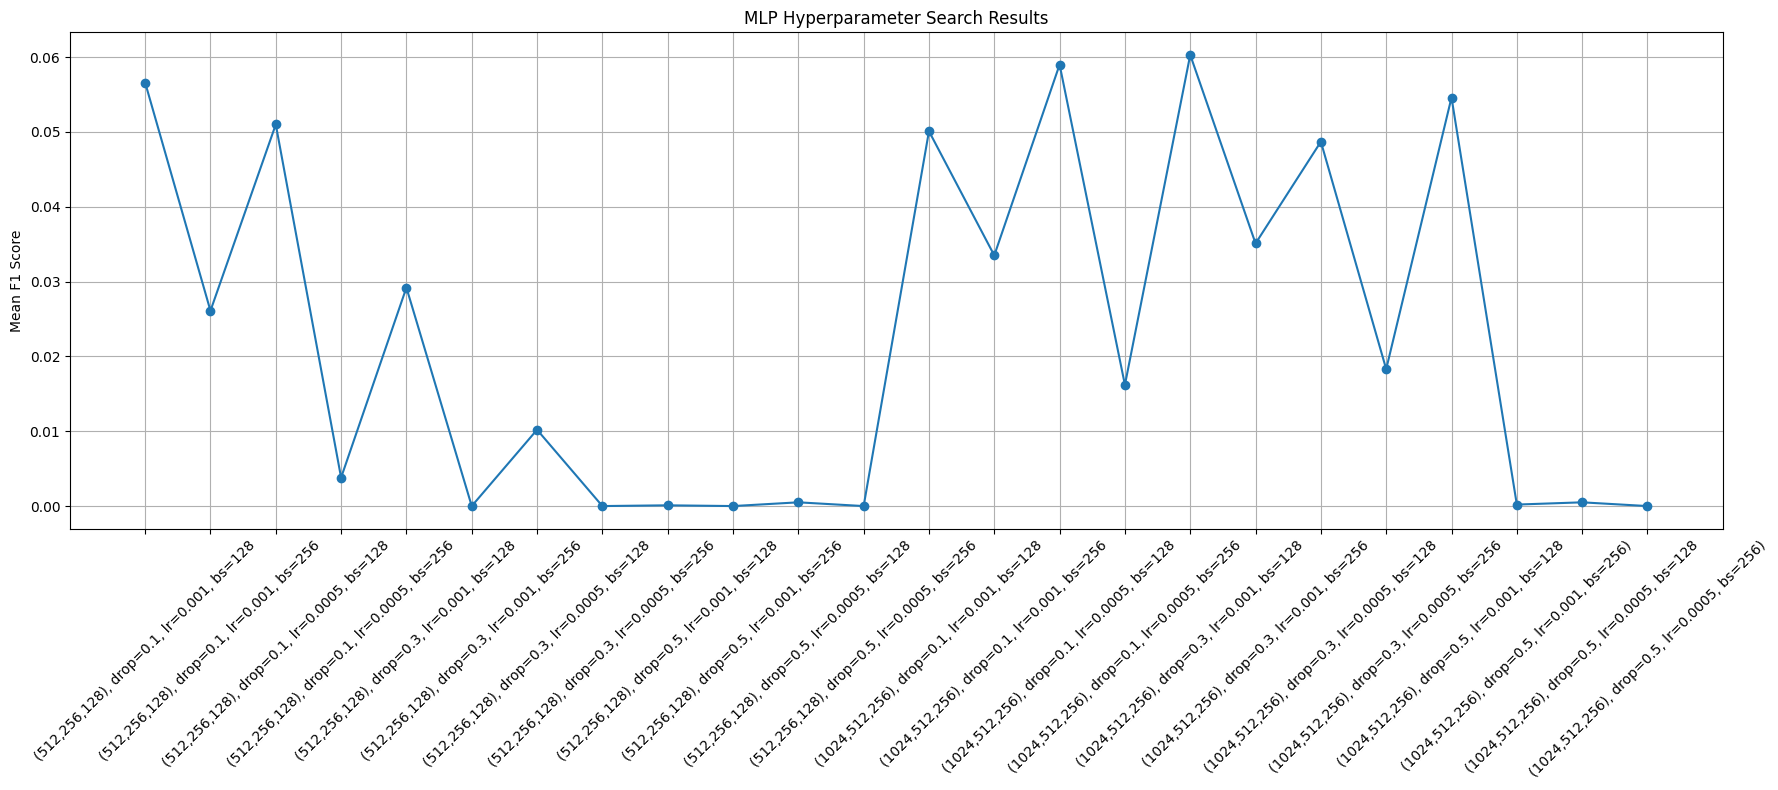

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted mean F1 scores from your logs
results = {
    "(512,256,128), drop=0.1, lr=0.001, bs=128": 0.0566,
    "(512,256,128), drop=0.1, lr=0.001, bs=256": 0.0261,
    "(512,256,128), drop=0.1, lr=0.0005, bs=128": 0.0510,
    "(512,256,128), drop=0.1, lr=0.0005, bs=256": 0.0038,
    "(512,256,128), drop=0.3, lr=0.001, bs=128": 0.0292,
    "(512,256,128), drop=0.3, lr=0.001, bs=256": 0.0000,
    "(512,256,128), drop=0.3, lr=0.0005, bs=128": 0.0102,
    "(512,256,128), drop=0.3, lr=0.0005, bs=256": 0.0000,
    "(512,256,128), drop=0.5, lr=0.001, bs=128": 0.0001,
    "(512,256,128), drop=0.5, lr=0.001, bs=256": 0.0000,
    "(512,256,128), drop=0.5, lr=0.0005, bs=128": 0.0005,
    "(512,256,128), drop=0.5, lr=0.0005, bs=256": 0.0000,

    "(1024,512,256), drop=0.1, lr=0.001, bs=128": 0.0501,
    "(1024,512,256), drop=0.1, lr=0.001, bs=256": 0.0335,
    "(1024,512,256), drop=0.1, lr=0.0005, bs=128": 0.0590,
    "(1024,512,256), drop=0.1, lr=0.0005, bs=256": 0.0162,

    "(1024,512,256), drop=0.3, lr=0.001, bs=128": 0.0603,  # ⭐ best
    "(1024,512,256), drop=0.3, lr=0.001, bs=256": 0.0351,
    "(1024,512,256), drop=0.3, lr=0.0005, bs=128": 0.0487,
    "(1024,512,256), drop=0.3, lr=0.0005, bs=256": 0.0183,

    "(1024,512,256), drop=0.5, lr=0.001, bs=128": 0.0546,
    "(1024,512,256), drop=0.5, lr=0.001, bs=256)": 0.0002,
    "(1024,512,256), drop=0.5, lr=0.0005, bs=128": 0.0005,
    "(1024,512,256), drop=0.5, lr=0.0005, bs=256)": 0.0000,
}

labels = list(results.keys())
values = list(results.values())

plt.figure(figsize=(18, 8))
plt.plot(values, marker='o')
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.ylabel("Mean F1 Score")
plt.title("MLP Hyperparameter Search Results")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import joblib
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#########################################
# 1. Load ProtBERT Test Embeddings
#########################################

X_test = np.load("embeddings/protbert_test.npy")
test_ids = np.load("embeddings/protbert_test_ids.npy", allow_pickle=True).astype(str)

print("Loaded ProtBERT test set:")
print("  X_test shape:", X_test.shape)
print("  test_ids:", len(test_ids))


#########################################
# 2. Load MultiLabelBinarizer (GO term mapping)
#########################################

mlb = joblib.load("mlb.pkl")
num_labels = len(mlb.classes_)
print("Number of GO terms:", num_labels)
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)


#########################################
# 4. Load best trained model
#########################################

input_dim = X_test.shape[1]
output_dim = num_labels

model = MLPClassifier(input_dim=input_dim, output_dim=output_dim)
model.load_state_dict(torch.load("best_mlp_model.pt", map_location=device))
model = model.to(device)
model.eval()

print("Loaded best_mlp_model.pt")


#########################################
# 5. Run Prediction
#########################################

from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
X_test_tensor = torch.tensor(X_test).float()
test_loader = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

all_probs = []

with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)

all_probs = np.vstack(all_probs)
print("Prediction complete. Probabilities shape:", all_probs.shape)

# Load from existing prediction files if needed
probs = all_probs              # shape (N, num_terms)
protein_ids = test_ids         # length N
go_terms = mlb.classes_        # list of GO IDs

submission_rows = []
max_terms = 1500  # CAFA limit

for i in range(len(protein_ids)):
    pid = protein_ids[i]
    row_probs = probs[i]

    # Select non-zero predictions (prob > 0)
    # NOTE: CAFA does not allow 0.0 scores → skip
    indices = np.where(row_probs > 0)[0]

    # Sort terms by descending probability
    sorted_idx = indices[np.argsort(-row_probs[indices])]

    # Enforce CAFA 1500-term limit
    sorted_idx = sorted_idx[:max_terms]

    for idx in sorted_idx:
        go_id = go_terms[idx]
        score = row_probs[idx]

        # Format: 1–3 significant figures, must be > 0
        score_str = f"{score:.3g}"

        # Append row
        submission_rows.append([pid, go_id, score_str])

# Create DataFrame
submission_df = pd.DataFrame(submission_rows, columns=["protein_id", "go_term", "score"])

# Save as TSV WITHOUT header
submission_df.to_csv("cafa_submission.tsv", sep="\t", index=False, header=False)

print("Saved CAFA submission file: cafa_submission.tsv")
print("Total prediction lines:", len(submission_df))


Using device: cuda
Loaded ProtBERT test set:
  X_test shape: (224309, 1024)
  test_ids: 224309
Number of GO terms: 26125


RuntimeError: Error(s) in loading state_dict for MLPClassifier:
	size mismatch for net.0.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for net.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for net.3.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for net.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.6.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for net.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for net.9.weight: copying a param with shape torch.Size([26125, 256]) from checkpoint, the shape in current model is torch.Size([26125, 128]).

In [ ]:
checkpoint = torch.load("best_mlp_model.pt", map_location="cpu")

for key, value in checkpoint.items():
    print(key, value.shape)
